In [31]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim


from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [32]:
import pyod

import pprint
from src.eval_methods import pot_eval, bf_search
from sklearn.preprocessing import MinMaxScaler


data_path = ''

In [33]:
def get_data(data_set):
    data_path = f'dataset/{data_set}'
    if data_set == 'SMD':
        index = 100000*2
        length = 50000
    elif data_set == 'PSM':
        index = 40000
        length = 20000
    elif data_set == 'MSL':
        index = 10000*3
        length = 20000
    else:
        index = 10000
        length = 20000
    if data_set == 'PSM':
        # scaler = StandardScaler()
        data = pd.read_csv(data_path + '/PSM_train.csv')[index:index + length]
        data = data.values[:, 1:]

        data = np.nan_to_num(data)

        # scaler.fit(data)
        # data = scaler.transform(data)
        test_data = pd.read_csv(data_path + '/PSM_test.csv')[index:index + length]

        test_data = test_data.values[:, 1:]
        test_data = np.nan_to_num(test_data)

        # test = scaler.transform(test_data)
        test = test_data

        train = data

        test_labels = pd.read_csv(data_path + '/PSM_test_label.csv')[index:index + length].values[:, 1:].astype(int)
    elif data_set == 'MSL':
        scaler = MinMaxScaler()
        data = np.load(data_path + f"/{data_set}_train.npy")[index:index + length]
        scaler.fit(data)
        data = scaler.transform(data)
        test_data = np.load(data_path + f"/{data_set}_test.npy")[index:index + length]
        scaler.fit(test_data)
        test = scaler.transform(test_data)
        test = test_data

        train = data
        val = test
        test_labels = np.load(data_path + f"/{data_set}_test_label.npy")[index:index + length].astype(int)
    else:
        # self.scaler = StandardScaler()
        data = np.load(data_path + f"/{data_set}_train.npy")[index:index + length]
        # self.scaler.fit(data)
        # data = self.scaler.transform(data)
        test_data = np.load(data_path + f"/{data_set}_test.npy")[index:index + length]
        # self.test = self.scaler.transform(test_data)
        test = test_data

        train = data
        val = test
        test_labels = np.load(data_path + f"/{data_set}_test_label.npy")[index:index + length].astype(int)
    print("test:", test.shape)
    print("train:", train.shape)
    return train,test,test_labels


In [34]:
def use_knn(X_train,X_test,labels):
    from pyod.models.knn import KNN   # kNN detector
    # train kNN detector
    clf_name = 'KNN'
    clf = KNN()
    clf.fit(X_train)

    # get the prediction on the test data
    # y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
    y_test_scores = clf.decision_function(X_test)  # outlier scores

    bf_eval = bf_search(y_test_scores, labels, start=0.001, end=1, step_num=150, verbose=False)
    return bf_eval
    
def use_iforest(X_train,X_test,labels):
    from pyod.models.iforest import IForest   # kNN detector
    # train kNN detector
    clf_name = 'IForest'
    clf = IForest()
    clf.fit(X_train)

    # get the prediction on the test data
    # y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
    y_test_scores = clf.decision_function(X_test)  # outlier scores

    bf_eval = bf_search(y_test_scores, labels, start=0.001, end=1, step_num=150, verbose=False)
    return bf_eval

def use_lof(X_train,X_test,labels):
    from pyod.models.lof import LOF   #  detector LOF
    # train LOF detector
    clf_name = 'LOF'
    clf = LOF()
    clf.fit(X_train)

    # get the prediction on the test data
    # y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
    y_test_scores = clf.decision_function(X_test)  # outlier scores

    bf_eval = bf_search(y_test_scores, labels, start=0.001, end=1, step_num=150, verbose=False)
    return bf_eval



In [36]:
data_sets = ['SMD', 'MSL', 'PSM', 'SMAP']
knn_bf_evals = []
if_bf_evals = []
lof_bf_evals = []
for i in range(4):
    X_train,X_test,labels = get_data(data_sets[i])
    knn_bf_evals.append(use_knn(X_train,X_test,labels))
    if_bf_evals.append(use_iforest(X_train,X_test,labels))
    lof_bf_evals.append(use_lof(X_train,X_test,labels))

test: (50000, 38)
train: (50000, 38)


/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')


Finding best f1-score by searching for threshold..


/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


Finding best f1-score by searching for threshold..


/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_vers

Finding best f1-score by searching for threshold..
test: (20000, 55)


UnboundLocalError: local variable 'train' referenced before assignment

In [ ]:
[knn_bf_evals[i] for i in range(4)]#10.19 

In [ ]:
[if_bf_evals[i] for i in range(4)]#10.19

In [ ]:
[lof_bf_evals[i] for i in range(4)]#10.19

In [45]:
data_sets = ['PSM']
knn_bf_evals = []
if_bf_evals = []
for d in data_sets:
    X_train,X_test,labels = get_data(d)
    if_bf_evals.append(use_iforest(X_train,X_test,labels))
for d in data_sets:
    X_train,X_test,labels = get_data(d)
    knn_bf_evals.append(use_knn(X_train,X_test,labels))
    

test: (20000, 25)
train: (20000, 25)


/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


Finding best f1-score by searching for threshold..
test: (20000, 25)
train: (20000, 25)


/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')


Finding best f1-score by searching for threshold..


In [46]:
knn_bf_evals[0]

{'f1': 0.32319997317145427,
 'precision': 0.19274999999999518,
 'recall': 0.9999999999998703,
 'TP': 77100000.0,
 'TN': 0.0,
 'FP': 322900000.0,
 'FN': 0.0,
 'threshold': 0.00766,
 'latency': 0.0}

In [48]:
if_bf_evals[0]

{'f1': 0.25844569640595544,
 'precision': 0.19274999999998768,
 'recall': 0.39209999999994916,
 'TP': 30230910.0,
 'TN': 196290910.0,
 'FP': 126609090.0,
 'FN': 46869090.0,
 'threshold': 0.00766,
 'latency': 5.066632889114072}

In [ ]:
[knn_bf_evals[i] for i in range(6)]

[{'f1': 0.9055141652466985,
  'precision': 0.9361701946582168,
  'recall': 0.8768115783186309,
  'TP': 484.0,
  'TN': 49415.0,
  'FP': 33.0,
  'FN': 68.0,
  'threshold': 0.6470199999999999,
  'latency': 1.7999880000799995},
 {'f1': 0.2581374886553627,
  'precision': 0.14899636245588527,
  'recall': 0.9650959776169635,
  'TP': 1106.0,
  'TN': 42537.0,
  'FP': 6317.0,
  'FN': 40.0,
  'threshold': 0.8001999999999999,
  'latency': 5.666635185360081},
 {'f1': 0.9650786133926046,
  'precision': 0.9928433773937699,
  'recall': 0.938833938212301,
  'TP': 3607.0,
  'TN': 46132.0,
  'FP': 26.0,
  'FN': 235.0,
  'threshold': 0.9933399999999999,
  'latency': 156.29319827530426},
 {'f1': 0.8169562798290976,
  'precision': 0.9890485934666372,
  'recall': 0.6958824929066157,
  'TP': 2890.0,
  'TN': 45815.0,
  'FP': 32.0,
  'FN': 1263.0,
  'threshold': 0.6403599999999999,
  'latency': 17.166571296826127},
 {'f1': 0.9916642318071238,
  'precision': 0.9932014771742801,
  'recall': 0.9901417067766993,
  

In [ ]:
[if_bf_evals[i] for i in range(6)]

[{'f1': 0.8025841617644053,
  'precision': 0.9919999735466675,
  'recall': 0.6739130312696915,
  'TP': 372.0,
  'TN': 49445.0,
  'FP': 3.0,
  'FN': 180.0,
  'threshold': 0.18081999999999998,
  'latency': 68.49828754281144},
 {'f1': 0.6128894655881907,
  'precision': 0.45827928898279596,
  'recall': 0.9249563619113755,
  'TP': 1060.0,
  'TN': 47601.0,
  'FP': 1253.0,
  'FN': 86.0,
  'threshold': 0.08757999999999999,
  'latency': 79.99885715918344},
 {'f1': 0.8250276210198544,
  'precision': 0.706340376888505,
  'recall': 0.9916710021039276,
  'TP': 3810.0,
  'TN': 44574.0,
  'FP': 1584.0,
  'FN': 32.0,
  'threshold': 0.0676,
  'latency': 20.615226036722795},
 {'f1': 0.8998584631802381,
  'precision': 0.8530744318164522,
  'recall': 0.9520828293954182,
  'TP': 3954.0,
  'TN': 45166.0,
  'FP': 681.0,
  'FN': 199.0,
  'threshold': 0.08757999999999999,
  'latency': 62.18711133055419},
 {'f1': 0.90528657841342,
  'precision': 0.9992559449460123,
  'recall': 0.8274799702558228,
  'TP': 1343.0

In [131]:
data_sets = ['SMD']
knn_bf_evals = []
if_bf_evals = []
for i in range(7):
    for d in data_sets:
        X_train,X_test,labels = get_data(d,i)
        knn_bf_evals.append(use_knn(X_train,X_test,labels))
    for d in data_sets:
        X_train,X_test,labels = get_data(d,i)
        if_bf_evals.append(use_iforest(X_train,X_test,labels))

test: (50000, 38)
train: (50000, 38)


/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')


Finding best f1-score by searching for threshold..
test: (50000, 38)
train: (50000, 38)


/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


Finding best f1-score by searching for threshold..
test: (50000, 38)
train: (50000, 38)


/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')


Finding best f1-score by searching for threshold..
test: (50000, 38)
train: (50000, 38)


/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


Finding best f1-score by searching for threshold..
test: (50000, 38)
train: (50000, 38)


/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')


Finding best f1-score by searching for threshold..
test: (50000, 38)
train: (50000, 38)


/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


Finding best f1-score by searching for threshold..
test: (50000, 38)
train: (50000, 38)


/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')


Finding best f1-score by searching for threshold..
test: (50000, 38)
train: (50000, 38)


/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


Finding best f1-score by searching for threshold..
test: (50000, 38)
train: (50000, 38)


/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')


Finding best f1-score by searching for threshold..
test: (50000, 38)
train: (50000, 38)


/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


Finding best f1-score by searching for threshold..
test: (50000, 38)
train: (50000, 38)


/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')


Finding best f1-score by searching for threshold..
test: (50000, 38)
train: (50000, 38)


/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


Finding best f1-score by searching for threshold..
test: (50000, 38)
train: (50000, 38)


/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')


Finding best f1-score by searching for threshold..
test: (50000, 38)
train: (50000, 38)


/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


Finding best f1-score by searching for threshold..


In [132]:
[knn_bf_evals[i] for i in range(7)]

[{'f1': 0.9055141652466985,
  'precision': 0.9361701946582168,
  'recall': 0.8768115783186309,
  'TP': 484.0,
  'TN': 49415.0,
  'FP': 33.0,
  'FN': 68.0,
  'threshold': 0.6470199999999999,
  'latency': 1.7999880000799995},
 {'f1': 0.2581374886553627,
  'precision': 0.14899636245588527,
  'recall': 0.9650959776169635,
  'TP': 1106.0,
  'TN': 42537.0,
  'FP': 6317.0,
  'FN': 40.0,
  'threshold': 0.8001999999999999,
  'latency': 5.666635185360081},
 {'f1': 0.9650786133926046,
  'precision': 0.9928433773937699,
  'recall': 0.938833938212301,
  'TP': 3607.0,
  'TN': 46132.0,
  'FP': 26.0,
  'FN': 235.0,
  'threshold': 0.9933399999999999,
  'latency': 156.29319827530426},
 {'f1': 0.8169562798290976,
  'precision': 0.9890485934666372,
  'recall': 0.6958824929066157,
  'TP': 2890.0,
  'TN': 45815.0,
  'FP': 32.0,
  'FN': 1263.0,
  'threshold': 0.6403599999999999,
  'latency': 17.166571296826127},
 {'f1': 0.9916642318071238,
  'precision': 0.9932014771742801,
  'recall': 0.9901417067766993,
  

In [133]:
[if_bf_evals[i] for i in range(7)]

[{'f1': 0.8025841617644053,
  'precision': 0.9919999735466675,
  'recall': 0.6739130312696915,
  'TP': 372.0,
  'TN': 49445.0,
  'FP': 3.0,
  'FN': 180.0,
  'threshold': 0.18081999999999998,
  'latency': 68.49828754281144},
 {'f1': 0.6128894655881907,
  'precision': 0.45827928898279596,
  'recall': 0.9249563619113755,
  'TP': 1060.0,
  'TN': 47601.0,
  'FP': 1253.0,
  'FN': 86.0,
  'threshold': 0.08757999999999999,
  'latency': 79.99885715918344},
 {'f1': 0.8250276210198544,
  'precision': 0.706340376888505,
  'recall': 0.9916710021039276,
  'TP': 3810.0,
  'TN': 44574.0,
  'FP': 1584.0,
  'FN': 32.0,
  'threshold': 0.0676,
  'latency': 20.615226036722795},
 {'f1': 0.8998584631802381,
  'precision': 0.8530744318164522,
  'recall': 0.9520828293954182,
  'TP': 3954.0,
  'TN': 45166.0,
  'FP': 681.0,
  'FN': 199.0,
  'threshold': 0.08757999999999999,
  'latency': 62.18711133055419},
 {'f1': 0.90528657841342,
  'precision': 0.9992559449460123,
  'recall': 0.8274799702558228,
  'TP': 1343.0

In [85]:
data_sets = ['SMD','MSL','PSM','SMAP']
knn_bf_evals = []
if_bf_evals = []
for d in data_sets:
    X_train,X_test,labels = get_data(d)
    knn_bf_evals.append(use_knn(X_train,X_test,labels))
for d in data_sets:
    X_train,X_test,labels = get_data(d)
    if_bf_evals.append(use_iforest(X_train,X_test,labels))

test: (50000, 38)
train: (50000, 38)


/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')


Finding best f1-score by searching for threshold..
test: (20000, 55)
train: (20000, 55)


/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')


Finding best f1-score by searching for threshold..
test: (20000, 25)
train: (20000, 25)


/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')


Finding best f1-score by searching for threshold..
test: (20000, 25)
train: (20000, 25)


/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')


Finding best f1-score by searching for threshold..
test: (50000, 38)
train: (50000, 38)


/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


Finding best f1-score by searching for threshold..
test: (20000, 55)
train: (20000, 55)


/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


Finding best f1-score by searching for threshold..
test: (20000, 25)
train: (20000, 25)


/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


Finding best f1-score by searching for threshold..
test: (20000, 25)
train: (20000, 25)


/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


Finding best f1-score by searching for threshold..


In [88]:
[knn_bf_evals[i] for i in range(4)]

[{'f1': 0.8947517365891016,
  'precision': 0.9916387876953279,
  'recall': 0.8151202693118882,
  'TP': 1186.0,
  'TN': 48535.0,
  'FP': 10.0,
  'FN': 269.0,
  'threshold': 0.9600399999999999,
  'latency': 87.4273224668219},
 {'f1': 0.8838765787954581,
  'precision': 0.9050185217075832,
  'recall': 0.8637094154171988,
  'TP': 2687,
  'TN': 16607,
  'FP': 282,
  'FN': 424,
  'threshold': 0.24741999999999997,
  'latency': 111.16481391976801},
 {'f1': 0.646540931576539,
  'precision': 0.477699999999988,
  'recall': 0.9999999999999476,
  'TP': 191080000.0,
  'TN': 0.0,
  'FP': 208920000.0,
  'FN': 0.0,
  'threshold': 0.00766,
  'latency': 0.0},
 {'f1': 0.5546171218692231,
  'precision': 0.4479637941483591,
  'recall': 0.7279411586288932,
  'TP': 297,
  'TN': 19226,
  'FP': 366,
  'FN': 111,
  'threshold': 0.5870799999999999,
  'latency': 84.99575021248937}]

In [89]:
[if_bf_evals[i] for i in range(4)]

[{'f1': 0.9114680860278866,
  'precision': 0.940102257559516,
  'recall': 0.884536076394941,
  'TP': 1287.0,
  'TN': 48463.0,
  'FP': 82.0,
  'FN': 168.0,
  'threshold': 0.11421999999999999,
  'latency': 29.66633704069955},
 {'f1': 0.9156576486558818,
  'precision': 0.9033468848816174,
  'recall': 0.9283188655470302,
  'TP': 2888,
  'TN': 16580,
  'FP': 309,
  'FN': 223,
  'threshold': 0.0343,
  'latency': 51.28498164311939},
 {'f1': 0.4860464001809686,
  'precision': 0.4776999999999758,
  'recall': 0.49469999999997405,
  'TP': 94527276.0,
  'TN': 105567276.0,
  'FP': 103352724.0,
  'FN': 96552724.0,
  'threshold': 0.00766,
  'latency': 26.713904087084472},
 {'f1': 0.7424884936801991,
  'precision': 0.5904486166360547,
  'recall': 0.9999999754901967,
  'TP': 408,
  'TN': 19309,
  'FP': 283,
  'FN': 0,
  'threshold': 0.24741999999999997,
  'latency': 24.332522249258357}]

In [21]:
def get_datai(data_set,i):
    data_path = f'dataset/{data_set}'
    if data_set == 'SMD':
        index = 100000*3
        length = 50000
    elif data_set == 'PSM':
        index = 0
        length = 20000
    else:
        index = 10000*i
        length = 20000
    if data_set == 'PSM':
        # scaler = StandardScaler()
        data = pd.read_csv(data_path + '/PSM_train.csv')[index:index + length]
        data = data.values[:, 1:]

        data = np.nan_to_num(data)

        # scaler.fit(data)
        # data = scaler.transform(data)
        test_data = pd.read_csv(data_path + '/PSM_test.csv')[index:index + length]

        test_data = test_data.values[:, 1:]
        test_data = np.nan_to_num(test_data)

        # test = scaler.transform(test_data)
        test = test_data

        train = data

        test_labels = pd.read_csv(data_path + '/PSM_test_label.csv')[index:index + length].values[:, 1:].astype(int)
    if data_set == 'MSL':
        scaler = MinMaxScaler()
        data = np.load(data_path + f"/{data_set}_train.npy")[index:index + length]
        scaler.fit(data)
        data = scaler.transform(data)
        test_data = np.load(data_path + f"/{data_set}_test.npy")[index:index + length]
        test_data = scaler.transform(test_data)
        test = test_data

        train = data
        test_labels = np.load(data_path + f"/{data_set}_test_label.npy")[index:index + length].astype(int)
    else:
        # self.scaler = StandardScaler()
        data = np.load(data_path + f"/{data_set}_train.npy")[index:index + length]
        # self.scaler.fit(data)
        # data = self.scaler.transform(data)
        test_data = np.load(data_path + f"/{data_set}_test.npy")[index:index + length]
        # self.test = self.scaler.transform(test_data)
        test = test_data

        train = data
        test_labels = np.load(data_path + f"/{data_set}_test_label.npy")[index:index + length].astype(int)
    print("test:", test.shape)
    print("train:", train.shape)
    print("test_labels:", test_labels.shape)
    return train,test,test_labels

data_sets = ['MSL']
lof_bf_evals = []
if_bf_evals = []
for i in range(5):
    for d in data_sets:
        X_train,X_test,labels = get_datai(d,i)
        lof_bf_evals.append(use_lof(X_train,X_test,labels))
    for d in data_sets:
        X_train,X_test,labels = get_datai(d,i)
        knn_bf_evals.append(use_knn(X_train,X_test,labels))
    for d in data_sets:
        X_train,X_test,labels = get_datai(d,i)
        if_bf_evals.append(use_iforest(X_train,X_test,labels))

test: (20000, 55)
train: (20000, 55)
test_labels: (20000,)


/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_vers

Finding best f1-score by searching for threshold..
test: (20000, 55)
train: (20000, 55)
test_labels: (20000,)


/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')


Finding best f1-score by searching for threshold..
test: (20000, 55)
train: (20000, 55)
test_labels: (20000,)


/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


Finding best f1-score by searching for threshold..
test: (20000, 55)
train: (20000, 55)
test_labels: (20000,)


/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_vers

Finding best f1-score by searching for threshold..
test: (20000, 55)
train: (20000, 55)
test_labels: (20000,)


/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')


Finding best f1-score by searching for threshold..
test: (20000, 55)
train: (20000, 55)
test_labels: (20000,)


/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


Finding best f1-score by searching for threshold..
test: (20000, 55)
train: (20000, 55)
test_labels: (20000,)


/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_vers

Finding best f1-score by searching for threshold..
test: (20000, 55)
train: (20000, 55)
test_labels: (20000,)


/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')


Finding best f1-score by searching for threshold..
test: (20000, 55)
train: (20000, 55)
test_labels: (20000,)


/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


Finding best f1-score by searching for threshold..
test: (20000, 55)
train: (20000, 55)
test_labels: (20000,)


/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_vers

Finding best f1-score by searching for threshold..
test: (20000, 55)
train: (20000, 55)
test_labels: (20000,)


/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')


Finding best f1-score by searching for threshold..
test: (20000, 55)
train: (20000, 55)
test_labels: (20000,)


/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


Finding best f1-score by searching for threshold..
test: (20000, 55)
train: (18317, 55)
test_labels: (20000,)


/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_vers

Finding best f1-score by searching for threshold..
test: (20000, 55)
train: (18317, 55)
test_labels: (20000,)


/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')


Finding best f1-score by searching for threshold..
test: (20000, 55)
train: (18317, 55)
test_labels: (20000,)


/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


Finding best f1-score by searching for threshold..


In [24]:
[knn_bf_evals[i] for i in range(5)]

[{'f1': 0.9230022512855854,
  'precision': 0.9640491912769669,
  'recall': 0.8853171117058335,
  'TP': 2038,
  'TN': 17622,
  'FP': 76,
  'FN': 264,
  'threshold': 0.9134199999999999,
  'latency': 114.873564080449},
 {'f1': 0.8838765787954581,
  'precision': 0.9050185217075832,
  'recall': 0.8637094154171988,
  'TP': 2687,
  'TN': 16607,
  'FP': 282,
  'FN': 424,
  'threshold': 0.24741999999999997,
  'latency': 111.16481391976801},
 {'f1': 0.8723427608372939,
  'precision': 0.8249457682756057,
  'recall': 0.9255293236175972,
  'TP': 3803,
  'TN': 15084,
  'FP': 807,
  'FN': 306,
  'threshold': 0.22077999999999998,
  'latency': 160.56913472664678},
 {'f1': 0.8856498819566361,
  'precision': 0.8781493317537822,
  'recall': 0.8932898374031227,
  'TP': 1917,
  'TN': 17588,
  'FP': 266,
  'FN': 229,
  'threshold': 0.6336999999999999,
  'latency': 64.57050613562663},
 {'f1': 0.8387046868661625,
  'precision': 0.8996539636738069,
  'recall': 0.785498477560446,
  'TP': 520,
  'TN': 19280,
  'F

In [23]:
[if_bf_evals[i] for i in range(5)]

[{'f1': 0.510799138104054,
  'precision': 0.9912390364050183,
  'recall': 0.3440486518503533,
  'TP': 792,
  'TN': 17691,
  'FP': 7,
  'FN': 1510,
  'threshold': 0.00766,
  'latency': 117.4941252937353},
 {'f1': 0.8930067546538943,
  'precision': 0.8602919247533752,
  'recall': 0.9283188655470302,
  'TP': 2888,
  'TN': 16420,
  'FP': 469,
  'FN': 223,
  'threshold': 0.02098,
  'latency': 44.71364694790075},
 {'f1': 0.9157185717040606,
  'precision': 0.9061234193325628,
  'recall': 0.9255293236175972,
  'TP': 3803,
  'TN': 15497,
  'FP': 394,
  'FN': 306,
  'threshold': 0.00766,
  'latency': 47.57074898930016},
 {'f1': 0.8246819454084952,
  'precision': 0.7927772966776556,
  'recall': 0.8592730621655494,
  'TP': 1844,
  'TN': 17372,
  'FP': 482,
  'FN': 302,
  'threshold': 0.00766,
  'latency': 36.57090612991243},
 {'f1': 0.5595192898448267,
  'precision': 0.8150288781783562,
  'recall': 0.4259818666770111,
  'TP': 282,
  'TN': 19274,
  'FP': 64,
  'FN': 380,
  'threshold': 0.00766,
  '

In [15]:
[lof_bf_evals[i] for i in range(5)]

[{'f1': 0.23922886270039054,
  'precision': 0.13586731975691005,
  'recall': 0.9999999956559513,
  'TP': 2302,
  'TN': 3057,
  'FP': 14641,
  'FN': 0,
  'threshold': 0.9999999999999999,
  'latency': 0.0},
 {'f1': 0.30274749067782636,
  'precision': 0.17838705966594753,
  'recall': 0.9996785567352022,
  'TP': 3110,
  'TN': 2565,
  'FP': 14324,
  'FN': 1,
  'threshold': 0.9999999999999999,
  'latency': 0.4444395062277086},
 {'f1': 0.36325565749822114,
  'precision': 0.22194015327755204,
  'recall': 0.9999999975663179,
  'TP': 4109,
  'TN': 1486,
  'FP': 14405,
  'FN': 0,
  'threshold': 0.9999999999999999,
  'latency': 0.2999970000299997},
 {'f1': 0.20859066643507787,
  'precision': 0.11644058593790527,
  'recall': 0.9999999953401677,
  'TP': 2146,
  'TN': 1570,
  'FP': 16284,
  'FN': 0,
  'threshold': 0.9999999999999999,
  'latency': 0.2222197531138543},
 {'f1': 0.08951909066614529,
  'precision': 0.04685730461009534,
  'recall': 0.9999999848942601,
  'TP': 662,
  'TN': 5872,
  'FP': 134

In [29]:
def get_dataPSM(data_set):
    data_path = f'dataset/{data_set}'
    if data_set == 'SMD':
        index = 100000*3
        length = 50000
    elif data_set == 'PSM':
        index = 40000
        length = 20000
    else:
        index = 10000
        length = 20000
    if data_set == 'PSM':
        # scaler = StandardScaler()
        data = pd.read_csv(data_path + '/PSM_train.csv')[index:index + length]
        data = data.values[:, 1:]

        data = np.nan_to_num(data)

        # scaler.fit(data)
        # data = scaler.transform(data)
        test_data = pd.read_csv(data_path + '/PSM_test.csv')[index:index + length]

        test_data = test_data.values[:, 1:]
        test_data = np.nan_to_num(test_data)

        # test = scaler.transform(test_data)
        test = test_data

        train = data

        test_labels = pd.read_csv(data_path + '/PSM_test_label.csv')[index:index + length].values[:, 1:]
    else:
        # self.scaler = StandardScaler()
        data = np.load(data_path + f"/{data_set}_train.npy")[index:index + length]
        # self.scaler.fit(data)
        # data = self.scaler.transform(data)
        test_data = np.load(data_path + f"/{data_set}_test.npy")[index:index + length]
        # self.test = self.scaler.transform(test_data)
        test = test_data

        train = data
        val = test
        test_labels = np.load(data_path + f"/{data_set}_test_label.npy")[index:index + length]
    print("test:", test.shape)
    print("train:", train.shape)
    return train,test,test_labels


In [27]:
train,test,test_labels = get_dataPSM('PSM')

test: (87841, 25)
train: (120000, 25)


<AxesSubplot:>

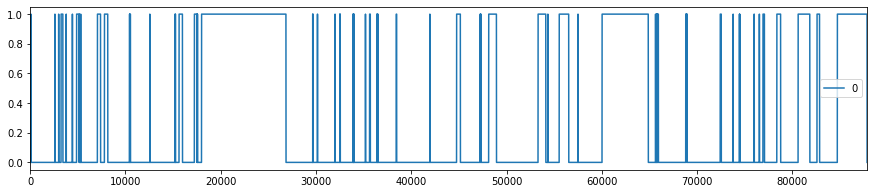

In [28]:
pd.DataFrame(test_labels).plot(figsize=(15,3))

In [30]:
for i in range(1):
    X_train,X_test,labels = get_dataPSM('PSM')
    for d in data_sets:
        lof_bf_evals.append(use_lof(X_train,X_test,labels))
    for d in data_sets:
        knn_bf_evals.append(use_knn(X_train,X_test,labels))
    for d in data_sets:
        if_bf_evals.append(use_iforest(X_train,X_test,labels))

test: (20000, 25)
train: (20000, 25)


/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_vers

Finding best f1-score by searching for threshold..


/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')


Finding best f1-score by searching for threshold..


/home/yons/anaconda3/envs/qisibo_pyod/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


Finding best f1-score by searching for threshold..
